In [1]:
import gc
import keras
import librosa
import os


import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn


class_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]
print(tf.config.list_physical_devices('GPU'))



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def preprocess(dataset_path, num_mfcc=40, n_fft=2048, hop_length=512, num_segment=10):
    # all_mfcc = np.empty([1000 * num_segment, 40, 130])
    # all_spec = np.empty([1000 * num_segment, 1025, 130])
    all_mel = np.empty([1000 * num_segment, 128, 130], dtype=np.float32)
    # all_chroma = np.empty([1000 * num_segment, 12, 130])
    labels = np.empty([1000 * num_segment], dtype=np.int32)
    sample_rate = 22050
    sample_per_segment = int(sample_rate*30/num_segment)

    count = 0
    for label_idx, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        if dirpath == dataset_path:
            continue

        for f in sorted(filenames):
            if not f.endswith('.wav'):
                continue
            file_path = str(str(dirpath).split('\\')[-1]) + '/' + str(f)
            print("Track Name", file_path)

            try:
                y, sr = librosa.load(path=dirpath + "\\" + f, sr=sample_rate)
            except:
                print("Exception")
                continue

            for n in range(num_segment):
                segment = y[sample_per_segment*n: sample_per_segment*(n + 1)]
                # Get mel-spectrogram
                mel = librosa.feature.melspectrogram(y=segment, sr=sr, n_fft=n_fft, hop_length=hop_length, dtype=np.float32)
                mel_db = librosa.power_to_db(mel)
                if mel_db.shape[0] == all_mel.shape[1] and mel_db.shape[1] == all_mel.shape[2]:
                    all_mel[count] = mel_db
                    labels[count] = label_idx - 1
                    count += 1

    # all_mfcc = all_mfcc.astype(np.float32)
    # all_spec = all_spec.astype(np.float32)
    # all_mel = all_mel.astype(np.float32)
    # all_chroma = all_chroma.astype(np.float32)
    print(count)
    all_mel = np.delete(all_mel, np.s_[count:], axis=0)
    labels = np.delete(labels, np.s_[count:])
    return all_mel, labels

In [3]:
mel, labels = preprocess(r"C:\Users\dpetr\Desktop\sxoli\music genre classification\MFCC-CNN\Data\genres_original")

print(mel.shape, mel.dtype, labels.shape, labels.dtype)

Track Name blues/blues.00000.wav
Track Name blues/blues.00001.wav
Track Name blues/blues.00002.wav
Track Name blues/blues.00003.wav
Track Name blues/blues.00004.wav
Track Name blues/blues.00005.wav
Track Name blues/blues.00006.wav
Track Name blues/blues.00007.wav
Track Name blues/blues.00008.wav
Track Name blues/blues.00009.wav
Track Name blues/blues.00010.wav
Track Name blues/blues.00011.wav
Track Name blues/blues.00012.wav
Track Name blues/blues.00013.wav
Track Name blues/blues.00014.wav
Track Name blues/blues.00015.wav
Track Name blues/blues.00016.wav
Track Name blues/blues.00017.wav
Track Name blues/blues.00018.wav
Track Name blues/blues.00019.wav
Track Name blues/blues.00020.wav
Track Name blues/blues.00021.wav
Track Name blues/blues.00022.wav
Track Name blues/blues.00023.wav
Track Name blues/blues.00024.wav
Track Name blues/blues.00025.wav
Track Name blues/blues.00026.wav
Track Name blues/blues.00027.wav
Track Name blues/blues.00028.wav
Track Name blues/blues.00029.wav
Track Name

C:\Users\dpetr\miniconda3\envs\tf\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


Track Name jazz/jazz.00056.wav
Track Name jazz/jazz.00057.wav
Track Name jazz/jazz.00058.wav
Track Name jazz/jazz.00059.wav
Track Name jazz/jazz.00060.wav
Track Name jazz/jazz.00061.wav
Track Name jazz/jazz.00062.wav
Track Name jazz/jazz.00063.wav
Track Name jazz/jazz.00064.wav
Track Name jazz/jazz.00065.wav
Track Name jazz/jazz.00066.wav
Track Name jazz/jazz.00067.wav
Track Name jazz/jazz.00068.wav
Track Name jazz/jazz.00069.wav
Track Name jazz/jazz.00070.wav
Track Name jazz/jazz.00071.wav
Track Name jazz/jazz.00072.wav
Track Name jazz/jazz.00073.wav
Track Name jazz/jazz.00074.wav
Track Name jazz/jazz.00075.wav
Track Name jazz/jazz.00076.wav
Track Name jazz/jazz.00077.wav
Track Name jazz/jazz.00078.wav
Track Name jazz/jazz.00079.wav
Track Name jazz/jazz.00080.wav
Track Name jazz/jazz.00081.wav
Track Name jazz/jazz.00082.wav
Track Name jazz/jazz.00083.wav
Track Name jazz/jazz.00084.wav
Track Name jazz/jazz.00085.wav
Track Name jazz/jazz.00086.wav
Track Name jazz/jazz.00087.wav
Track Na

In [172]:
def prepare_datasets(test_size, validation_size):

    x_train, x_test, y_train, y_test = train_test_split(mel, labels, test_size=test_size, stratify=labels)
    x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=validation_size, stratify=y_train)

    x_train = x_train[..., np.newaxis]
    x_validation = x_validation[..., np.newaxis]
    x_test = x_test[..., np.newaxis]

    return x_train, x_test, x_validation, y_train, y_test, y_validation


mel_train, mel_test, mel_validation, y_train, y_test, y_validation = prepare_datasets(test_size=1500, validation_size=1500)

print(mel_train.shape, y_train.shape, mel_validation.shape, y_validation.shape, mel_test.shape, y_test.shape)

(6986, 128, 130, 1) (6986,) (1500, 128, 130, 1) (1500,) (1500, 128, 130, 1) (1500,)


In [2]:
mel_file = np.load(r'C:\Users\dpetr\Desktop\sxoli\Level 3\Individual\datasets\GTZAN\mel_spectogram_train_validation_test.npz')

mel_train = mel_file['mel_spec_train']
mel_validation = mel_file['mel_spec_validation']
mel_test = mel_file['mel_spec_test']

y_train = mel_file['y_train']
y_validation = mel_file['y_validation']
y_test= mel_file['y_test']

In [173]:
print("X shape: ", mel_train.shape, mel_validation.shape, mel_test.shape)
print("Y shape: ", y_train.shape, y_validation.shape, y_test.shape)


X shape:  (6986, 128, 130, 1) (1500, 128, 130, 1) (1500, 128, 130, 1)
Y shape:  (6986,) (1500,) (1500,)


In [4]:
# maximum = np.amax(mel_train)
# mel_train = mel_train/np.amax(maximum)
# mel_validation = mel_validation/np.amax(maximum)
# mel_test = mel_test/np.amax(maximum)

In [174]:
mean = np.mean(mel_train)
std = np.std(mel_train)
mel_train = (mel_train - mean) / std
mel_test = (mel_test - mean) / std
mel_validation = (mel_validation - mean) / std

In [176]:
print(mean)
print(std)

-12.840668
16.634521


In [177]:
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 699]
 [  1 699]
 [  2 699]
 [  3 699]
 [  4 699]
 [  5 692]
 [  6 699]
 [  7 700]
 [  8 700]
 [  9 700]]


In [178]:
unique, counts = np.unique(y_validation, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 151]
 [  1 150]
 [  2 150]
 [  3 150]
 [  4 150]
 [  5 149]
 [  6 150]
 [  7 150]
 [  8 150]
 [  9 150]]


In [179]:
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 150]
 [  1 150]
 [  2 150]
 [  3 150]
 [  4 150]
 [  5 149]
 [  6 151]
 [  7 150]
 [  8 150]
 [  9 150]]


In [284]:
def build_model(input_shape):

    #create model
    model = keras.Sequential()

    #1st conv layer
    model.add(keras.layers.Conv2D(128, (3, 3), input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(0.000005)))
    model.add(keras.layers.MaxPool2D((3,3), strides=(3,3), padding='same'))
    # model.add(keras.layers.BatchNormalization(momentum=0.9))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.5))

    #2nd conv layer
    model.add(keras.layers.Conv2D(128, (3, 3), input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(0.000005)))
    model.add(keras.layers.MaxPool2D((3,3), strides=(3,3), padding='same'))
    # model.add(keras.layers.BatchNormalization(momentum=0.9))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.5))

    #3rd conv layer
    model.add(keras.layers.Conv2D(256, (3, 3), input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(0.000005)))
    model.add(keras.layers.MaxPool2D((3,3), strides=(3,3), padding='valid'))
    # model.add(keras.layers.BatchNormalization(momentum=0.9))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.5))

    # #4th conv layer
    # model.add(keras.layers.Conv2D(128, (3, 3), input_shape=input_shape))
    # model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding='same'))
    # model.add(keras.layers.BatchNormalization(momentum=0.9))
    # model.add(keras.layers.ReLU())
    # model.add(keras.layers.Dropout(0.2))


    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))) # 512 best
    model.add(keras.layers.Dropout(0.65))

    # model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.00005)))
    # model.add(keras.layers.Dropout(0.6))

    #output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [285]:
input_shape = mel_train[0].shape
model = build_model(input_shape)
optimizer = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [286]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 128, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 43, 128)      0         
 )                                                               
                                                                 
 re_lu (ReLU)                (None, 42, 43, 128)       0         
                                                                 
 dropout (Dropout)           (None, 42, 43, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 41, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                    

Epoch 1/10
219/219 [==============================] - 8s 37ms/step - loss: 0.4205 - accuracy: 0.8683 - val_loss: 0.4352 - val_accuracy: 0.8687
Epoch 2/10
219/219 [==============================] - 8s 37ms/step - loss: 0.4101 - accuracy: 0.8758 - val_loss: 0.4048 - val_accuracy: 0.8780
Epoch 3/10
219/219 [==============================] - 8s 37ms/step - loss: 0.4014 - accuracy: 0.8713 - val_loss: 0.4227 - val_accuracy: 0.8707
Epoch 4/10
219/219 [==============================] - 8s 37ms/step - loss: 0.4139 - accuracy: 0.8693 - val_loss: 0.4050 - val_accuracy: 0.8753
Epoch 5/10
219/219 [==============================] - 8s 37ms/step - loss: 0.4030 - accuracy: 0.8740 - val_loss: 0.4427 - val_accuracy: 0.8720
Epoch 6/10
219/219 [==============================] - 8s 37ms/step - loss: 0.4038 - accuracy: 0.8715 - val_loss: 0.4270 - val_accuracy: 0.8727
Epoch 7/10
219/219 [==============================] - 8s 37ms/step - loss: 0.4059 - accuracy: 0.8673 - val_loss: 0.4100 - val_accuracy: 0.8780

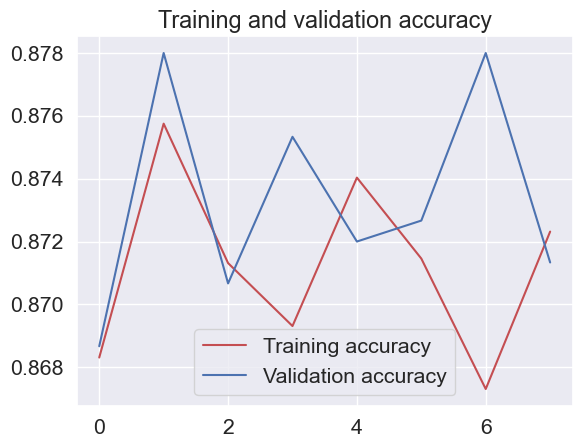

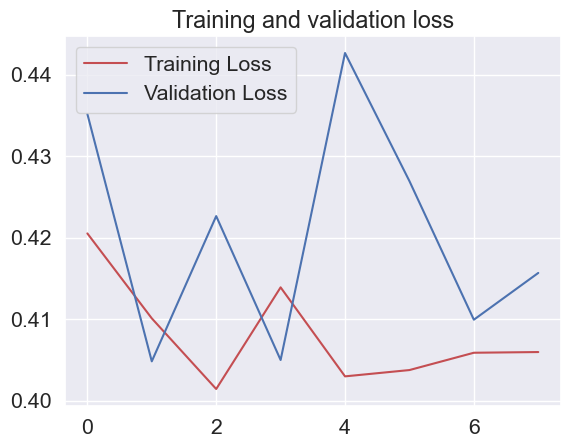

Accuracy on test set is:0.8886666893959045


In [289]:
history = model.fit(mel_train, y_train,
                    validation_data=(mel_validation, y_validation),
                    epochs=90,
                    batch_size=32,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                patience=6,
                                                                verbose=1,
                                                                restore_best_weights=True)]
          )

test_error, test_accuracy = model.evaluate(mel_test, y_test, verbose=1)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy' + str())
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

print("Accuracy on test set is:{}".format(test_accuracy))



In [283]:
del model
keras.backend.clear_session()
gc.collect()

39001

47/47 [==============================] - 1s 18ms/step


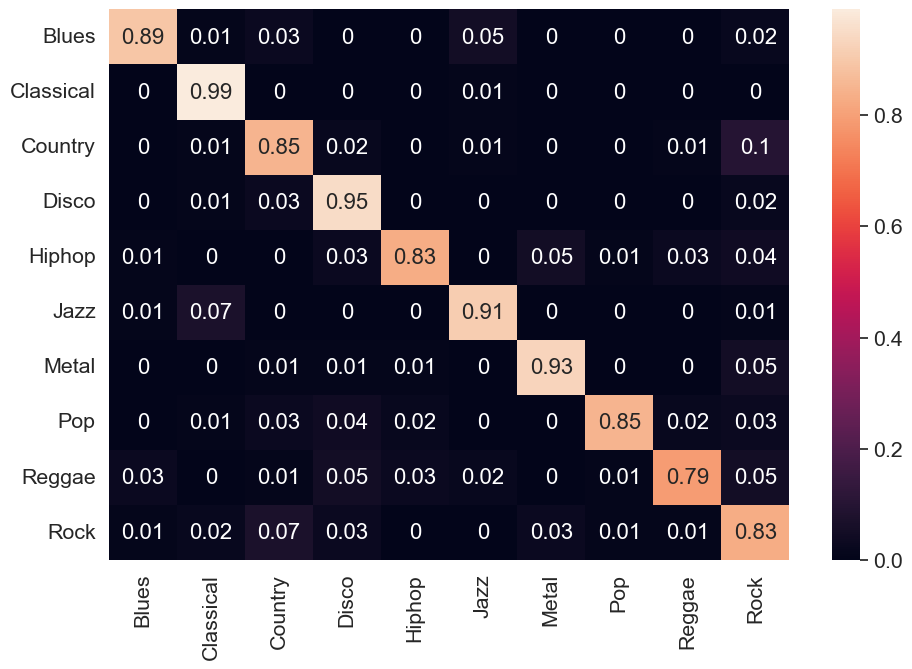

In [288]:
predictions = model.predict(mel_test, batch_size=32, verbose=1)
predicted_indexes = []
for prediction in predictions:
    predicted_indexes.append(np.argmax(prediction))
predicted_indexes
conf_mat = confusion_matrix(y_test, predicted_indexes, normalize= 'true')
conf_mat = np.round(conf_mat, 2)
conf_mat_df = pd.DataFrame(conf_mat, columns= class_names, index= class_names)
plt.figure(figsize = (10,7), dpi = 100)
sn.set(font_scale=1.4)
sn.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16}) # font size
plt.tight_layout()

In [74]:
model.save('saved_models/CNN-MEL-91,5test')

INFO:tensorflow:Assets written to: saved_models/CNN-MEL-91,5test\assets


INFO:tensorflow:Assets written to: saved_models/CNN-MEL-91,5test\assets
